In [13]:
import sklearn as sk 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # data visualization library
from sklearn.datasets import fetch_olivetti_faces
from sklearn.decomposition import TruncatedSVD 

np.random.seed()

# lets explore movies.csv
movies= pd.read_csv('movies.csv') # not used, just information about the movies
ratings=pd.read_csv('data/ratings.csv',sep=',')

#init values
tmax = 100
r = 5
labda = 1

#convert sparse representation to data matrix
df_movie_ratings = ratings.pivot(
    index='userId',
    columns='movieId',
    values='rating'
).fillna(0)  #fill unobserved entries with μ

#filter only movies with more then 200 ratings
keep_movie = np.sum(df_movie_ratings!=0,0)>200
df_D = df_movie_ratings.loc[:,keep_movie]

#filter out all users with less then 5 movie ratings
keep_user = np.sum(df_D!=0,1)>5
df_D = df_D.loc[keep_user,:]

#convert to data matrix
D = df_D.to_numpy()

In [14]:
def InitRandom(n, d, r ):
    X = np.random.rand(d, r)
    Y = np.random.rand(n, r)
    return X, Y

def IndicatorNonzero(D):
    return ( D != 0).astype(int)

In [15]:
n, d = D.shape
X, Y = InitRandom(n, d, r)
O = IndicatorNonzero(D)
t = 1
print("n: " + str(n) + " d " + str(d) )
print("D shape:" + str(D.shape) + " O shape" + str(O.shape))

n: 344 d 18
D shape:(344, 18) O shape(344, 18)


In [16]:
mses = []

def matrix_completion(D, r, tmax=100, labda=0.00001):
    n, d = D.shape #n = 344, d = 18
    X, Y = InitRandom(n, d, r) # = (d,r), Y = (n,r)
    O = IndicatorNonzero(D)
    t = 1

    while t < tmax:
        for k in range(d):
            OXk = np.diag(O[:, k])
            X[k,] = D[:,k].T.dot(Y) @ np.linalg.inv(Y.T @ OXk @ Y + labda*np.eye(r))
        for i in range(n):
            OYi = np.diag(O[i,:])
            result = D[i,].dot(X) @ np.linalg.inv(X.T @ OYi @ X + labda*np.eye(r))
            Y[i,] =  result
            
        mse = (1/np.sum(O)) * (np.linalg.norm(D - np.multiply(O,(Y @ X.T)), ord = 2))**2

        mses.append(mse)
        t += 1

    return X, Y

# Run matrix completion algorithm
X, Y = matrix_completion(D, r, tmax, labda)

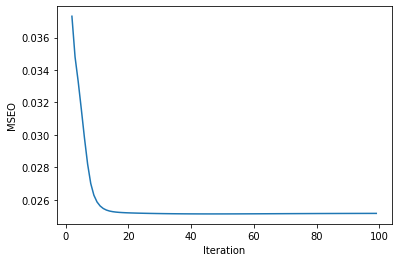

In [17]:
# Plot MSEO vs. iteration
plt.plot(range(2, tmax), mses[1:])
plt.xlabel('Iteration')
plt.ylabel('MSEO')

plt.show()

In [18]:
X.shape, Y.shape

((18, 5), (344, 5))

In [19]:
S = X @ Y.T

In [20]:
S.shape

(18, 344)

In [21]:
S[:3]

array([[4.04239227, 6.35676483, 3.89396435, ..., 2.90554271, 3.2817925 ,
        3.99808562],
       [4.04279628, 2.01437895, 4.30257726, ..., 4.15615614, 3.40310873,
        5.22652302],
       [4.7249373 , 4.2983636 , 4.13316981, ..., 4.55547048, 3.74741093,
        4.13267958]])

In [22]:
df = pd.DataFrame(S)
df.iloc[:,0:3]

,0,1,2
0,4.042392,6.356765,3.893964
1,4.042796,2.014379,4.302577
2,4.724937,4.298364,4.133170
3,4.199764,1.216308,3.512668
4,3.968117,5.314398,3.182226
5,4.908675,5.010748,3.799950
6,4.662487,1.991242,4.455772
7,4.843582,5.883062,4.256425
8,4.330389,4.978242,3.936173
9,3.798452,2.076971,3.378264


In [11]:
from numpy.linalg import eigvals

def check_minimum(X, Y, D):
    """
    Check if the point (U, V) is a local minimum or a global minimum.
    
    Parameters:
    - X: user matrix
    - Y: item matrix
    - D: user-item rating matrix
    
    Returns:
    - is_minimum: boolean indicating if the point is a local minimum
    """
    m, k = X.shape
    k, n = Y.shape
    
    # Compute Hessian matrix
    XYT = np.dot(X, Y.T)
    H_X = np.zeros((k, k))
    for i in range(m):
        for j in range(n):
            if D[i, j] > 0:
                d_ij = D[i, j] - XYT[i, j]
                H_X += np.outer(Y[:, j], Y[:, j]) * d_ij
    H_X *= 2
    H_Y = H_X.T
    
    # Check eigenvalues of Hessian matrix
    eig_H_X = eigvals(H_X)
    eig_H_Y = eigvals(H_Y)
    is_minimum = (eig_H_X > 0).all() and (eig_H_Y > 0).all()
    return is_minimum


if all eigenvalues of the Hessian matrix are positive, that means that the point (U, V) is a local minimum of the objective function. If that's the case the function returns True, otherwise it returns False.

In [12]:
is_local_minimum = check_minimum(X, Y, D)
print(is_local_minimum)

False
